In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATASET_PATH_FMT = "/content/drive/MyDrive/Datasets/Loan_Eligibility/{}"

TRAIN_DATA_PATH = DATASET_PATH_FMT.format("p_train.csv")
TEST_DATA_PATH = DATASET_PATH_FMT.format("p_test.csv")

In [ ]:
train = pd.read_csv(TRAIN_DATA_PATH)
test = pd.read_csv(TEST_DATA_PATH)

In [ ]:
train

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income
0,1,0,0,0,0,5849,0.0,128.0,360.0,1.0,2,1,5849.0
1,1,1,1,0,0,4583,1508.0,128.0,360.0,1.0,0,0,6091.0
2,1,1,0,0,1,3000,0.0,66.0,360.0,1.0,2,1,3000.0
3,1,1,0,1,0,2583,2358.0,120.0,360.0,1.0,2,1,4941.0
4,1,0,0,0,0,6000,0.0,141.0,360.0,1.0,2,1,6000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,0,0,0,0,0,2900,0.0,71.0,360.0,1.0,0,1,2900.0
610,1,1,3,0,0,4106,0.0,40.0,180.0,1.0,0,1,4106.0
611,1,1,1,0,0,8072,240.0,253.0,360.0,1.0,2,1,8312.0
612,1,1,2,0,0,7583,0.0,187.0,360.0,1.0,2,1,7583.0


In [ ]:
X = train.drop(["Loan_Status"], axis=1)
y = train["Loan_Status"]

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

# Models

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

models = {
    "Logistic Regression": {
        "model": LogisticRegression,
        "params" : dict(penalty='l2', C=1.0, class_weight='balanced', random_state=42, max_iter=1000)
    },
    "Random Forest": {
        "model": RandomForestClassifier,
        "params": dict(n_estimators=100, max_depth=5, class_weight='balanced', random_state=42)
    },
    "SVM": {
        "model": SVC,
        "params": dict(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', random_state=42, probability=True)
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier,
        "params": dict(n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.8, random_state=42)
    },
}

In [ ]:
set(train.columns) - set(test.columns)

{'Loan_Status'}

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

def cross_validation(model_name, model_class, model_params, splits=5):
  mean = 0
  kf = StratifiedKFold(n_splits=splits, shuffle=True)
  for i, (idx_train, idx_test) in enumerate(kf.split(X, y)):
    model = model_class(**model_params)
    model.fit(
        X.loc[idx_train],
        y.loc[idx_train],
    )
    y_pred = model.predict(
        X.loc[idx_test],
    )
    y_true = y.loc[idx_test]
    accuracy = accuracy_score(y_pred, y_true) * 100
    print(f"[i] Iteration {i+1} :: {splits} of {model_name} == {accuracy:.4f}%")
    mean += accuracy / splits
    yield {"pred" : y_pred, "true": y_true, "test": model.predict(test), "probabilities":model.predict_proba(X.loc[idx_test])[:, 1]}
  print(f"[i] Average Accuracy of {model_name}: {mean:.4f}%")

In [ ]:
result = {}
for model_name in models:
  result[model_name] = [*cross_validation(
      model_name,
      models[model_name]["model"],
      models[model_name]["params"],
  )]
  print("-" * 70)

[i] Iteration 1 :: 5 of Logistic Regression == 77.2358%
[i] Iteration 2 :: 5 of Logistic Regression == 79.6748%
[i] Iteration 3 :: 5 of Logistic Regression == 73.1707%
[i] Iteration 4 :: 5 of Logistic Regression == 75.6098%
[i] Iteration 5 :: 5 of Logistic Regression == 76.2295%
[i] Average Accuracy of Logistic Regression: 76.3841%
----------------------------------------------------------------------
[i] Iteration 1 :: 5 of Random Forest == 75.6098%
[i] Iteration 2 :: 5 of Random Forest == 82.1138%
[i] Iteration 3 :: 5 of Random Forest == 85.3659%
[i] Iteration 4 :: 5 of Random Forest == 82.9268%
[i] Iteration 5 :: 5 of Random Forest == 79.5082%
[i] Average Accuracy of Random Forest: 81.1049%
----------------------------------------------------------------------
[i] Iteration 1 :: 5 of SVM == 44.7154%
[i] Iteration 2 :: 5 of SVM == 49.5935%
[i] Iteration 3 :: 5 of SVM == 54.4715%
[i] Iteration 4 :: 5 of SVM == 53.6585%
[i] Iteration 5 :: 5 of SVM == 68.8525%
[i] Average Accuracy of SV

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

colors = ['red', 'blue', 'green', 'purple', 'orange']

def plot_roc_curve(true_values, prob_values, axis):
  for j, (true, prob) in enumerate(zip(true_values, prob_values)):
      tpr, fpr, _ = roc_curve(true, prob)
      # calculate area under the ROC curve (AUC)
      roc_auc = auc(tpr, fpr)
      
      # plot the ROC curve
      axis.plot(tpr, fpr, color=colors[j], lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')

  return [roc_auc_score(true, prob) for true, prob in zip(true_values, prob_values)]

-------	 Logistic Regression 	-------
0.73	0.81	0.63	0.74	0.73	
Average AUC:  0.7295973153093895
-------	 Random Forest 	-------
0.68	0.78	0.89	0.76	0.72	
Average AUC:  0.7654752265278582
-------	 SVM 	-------
0.60	0.48	0.56	0.48	0.43	
Average AUC:  0.5100470822607045
-------	 Gradient Boosting 	-------
0.82	0.66	0.83	0.71	0.77	
Average AUC:  0.7560019770391287


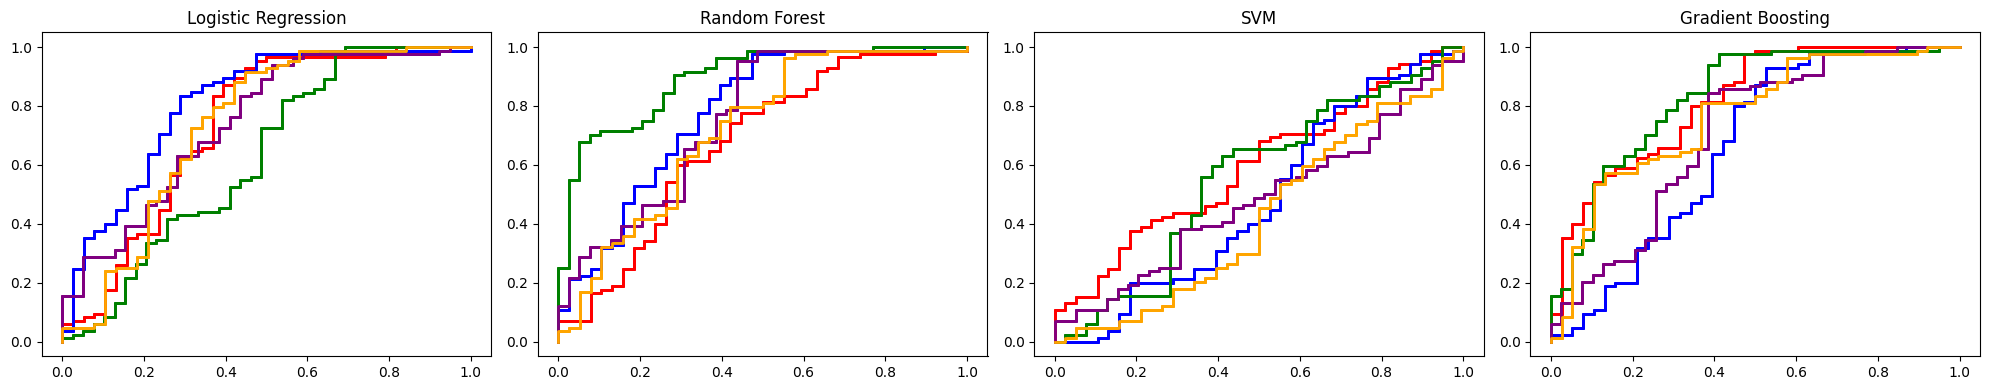

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, len(result), figsize=(20, 4))

colors = ['red', 'blue', 'green', 'purple', 'orange']


for i, (model_name, output) in enumerate(result.items()):
  axes[i].set_title(model_name)
  for out in output:
    scores = plot_roc_curve(
        true_values = [result[model_name][i]["true"] for i in range(len(result[model_name]))],
        prob_values = [result[model_name][i]["probabilities"] for i in range(len(result[model_name]))],
        axis=axes[i]
    )
  print(f"-------\t {model_name} \t-------")
  score_format = "{:.2f}\t" * len(scores)
  print(score_format.format(*scores))
  print("Average AUC: ", sum(scores) / len(scores))

fig.tight_layout()

In [ ]:
columns = [f"{model_name}-{i}" for model_name in result for i in range(5)]

df_export = pd.DataFrame(columns=columns)

for model_name, values in result.items():
  for i, value in enumerate(values):
    df_export[f"{model_name}-{i}"] = value["test"]

df_export.to_csv(DATASET_PATH_FMT.format("result.csv"))